Y_data: 20640
y_data: 19648
y_data: 18665
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10; total time=   0.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2; total time=   0.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf

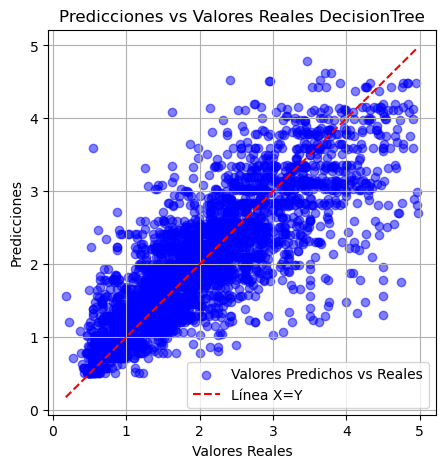


Epsilon = 1e-07
Error del ruido:
MSE: 3521476182091376.0
MAE: 14793671.467900446
RMSE: 59342027.11478077
R2: -1464083048654497.2

Predicción de precios con ruido:
MSE: 0.3051420442506372
MAE: 0.3829550367186715
RMSE: 0.5523966367119166
R2: 0.6802555204176179

Epsilon = 0.0001
Error del ruido:
MSE: 3422887556.868776
MAE: 14631.287600984344
RMSE: 58505.448950236896
R2: -1423094005.6974301

Predicción de precios con ruido:
MSE: 0.3022315887892506
MAE: 0.3793756849874366
RMSE: 0.5497559356562243
R2: 0.6833052544165302

Epsilon = 0.1
Error del ruido:
MSE: 3354.743425288139
MAE: 14.577820936245546
RMSE: 57.92014697225948
R2: -1393.7625165059387

Predicción de precios con ruido:
MSE: 0.31158080108187053
MAE: 0.3845656068481932
RMSE: 0.5581942323975325
R2: 0.6735086397731755

Epsilon = 0.5
Error del ruido:
MSE: 145.39849659629473
MAE: 2.9913213928669347
RMSE: 12.058129896310403
R2: -59.45063580127891

Predicción de precios con ruido:
MSE: 0.30349126116799957
MAE: 0.3820677135487533
RMSE: 0.55

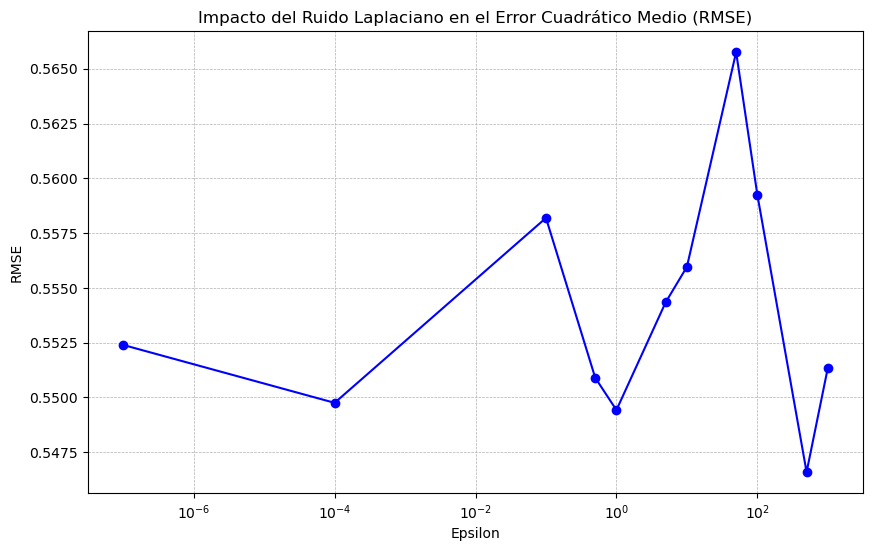

In [8]:
import numpy as np
import ModeloBase
from ModeloBase import read_data_model, add_laplace_noise, rmse
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as r2
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 

#np.random.seed(42) 


all_data = fetch_california_housing()
X_train_val, X_val, X_test, Y_train_val, Y_val, Y_test = read_data_model(all_data, 'MedInc')

# Entrenamos el scanner con los datos train_val para evitar fuga de datos antes del entrenamiento
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


tree_model = DecisionTreeRegressor(random_state=42)

# Definir los parámetros para la búsqueda en cuadrícula
param_grid = {
    'max_depth': [None, 10, 20, 30],        # Profundidad máxima del árbol
    'min_samples_split': [2, 10, 20],       # Número mínimo de muestras necesarias para dividir un nodo
    'min_samples_leaf': [1, 5, 10],         # Número mínimo de muestras que debe tener una hoja
    'max_features': [None, 'sqrt', 'log2']  # Número de características a considerar en cada división
}

# Configurar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Entrenar el modelo con la búsqueda de hiperparámetros
grid_search.fit(X_train_val_scaled, Y_train_val)
best_params = grid_search.best_params_

# Imprimir los mejores parámetros encontrados
print("Best parameters found:", best_params)

# Entrenamiento del modelo original sin ruido
model_original = DecisionTreeRegressor(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42)
model_original.fit(X_train_val_scaled, Y_train_val)
Y_predict = model_original.predict(X_test_scaled)

# Evaluacion del modelo original sin ruido
MSE_original = mse(Y_test, Y_predict)
MAE_original = mae(Y_test, Y_predict)
RMSE_original = rmse(Y_test, Y_predict)
R2_original = r2(Y_test, Y_predict)

print("Predicción de precios de casas sin ruido:")
print(f"MSE: {MSE_original}")
print(f"MAE: {MAE_original}")
print(f"RMSE: {RMSE_original}")
print(f"R2: {R2_original}")

# Diagrama de dispersión de valores predichos vs valores reales
plt.figure(figsize=(5, 5))
plt.scatter(Y_test, Y_predict, alpha=0.5, color='blue', label='Valores Predichos vs Reales')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--', label='Línea X=Y')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales DecisionTree')
plt.legend()
plt.grid(True)

# Guardar la imagen
plt.savefig('diagrama_dispersion_DecisionTree.png',  dpi=300)
plt.show()

# Iterar sobre diferentes valores de epsilon
epsilon_values = [0.0000001, 0.0001, 0.1, 0.5, 1.0, 5 , 10, 50, 100, 500, 1000]
results = []

for epsilon in epsilon_values:
    print(f"\nEpsilon = {epsilon}")

    # Paso 1: Agregar ruido laplaciano a la columna de ingresos en el conjunto de entrenamiento
    X_train_val_noisy = add_laplace_noise(X_train_val, epsilon)

    MSE_original = mse(X_train_val, X_train_val_noisy)
    MAE_original = mae(X_train_val, X_train_val_noisy)
    RMSE_original = rmse(X_train_val, X_train_val_noisy)
    R2_original = r2(X_train_val, X_train_val_noisy)

    print("Error del ruido:")
    print(f"MSE: {MSE_original}")
    print(f"MAE: {MAE_original}")
    print(f"RMSE: {RMSE_original}")
    print(f"R2: {R2_original}")
    
    # Paso 2: Entrenar el modelo utilizando los valores de ingresos con ruido
    scaler = StandardScaler()
    X_train_val_noisy_scaled = scaler.fit_transform(X_train_val_noisy)
    X_test_scaled = scaler.transform(X_test)

    model_noisy = DecisionTreeRegressor(
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        random_state=42)
    model_noisy.fit(X_train_val_noisy_scaled, Y_train_val)
    Y_predict = model_noisy.predict(X_test_scaled)

    # Paso 3: Evaluar el modelo entrenado con datos ruidosos usando el conjunto de validación original
    MSE_noisy = mse(Y_test, Y_predict)
    MAE_noisy = mae(Y_test, Y_predict)
    RMSE_noisy = rmse(Y_test, Y_predict)
    R2_noisy = r2(Y_test, Y_predict)

    print("\nPredicción de precios con ruido:")
    print(f"MSE: {MSE_noisy}")
    print(f"MAE: {MAE_noisy}")
    print(f"RMSE: {RMSE_noisy}")
    print(f"R2: {R2_noisy}")

    results.append((epsilon,MSE_noisy ,MAE_noisy, RMSE_noisy, R2_noisy))

# Mostrar los resultados
import pandas as pd
results_df = pd.DataFrame(results, columns=["Epsilon", "MSE" ,"MAE", "RMSE", "R2"])
print(results_df)


# Graficar el RMSE en función del valor de epsilon
plt.figure(figsize=(10, 6))
plt.plot(results_df["Epsilon"], results_df["RMSE"], marker='o', linestyle='-', color='blue')
plt.xscale('log')  # Usar escala logarítmica para epsilon
plt.xlabel('Epsilon')
plt.ylabel('RMSE')
plt.title('Impacto del Ruido Laplaciano en el Error Cuadrático Medio (RMSE)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('DTree_rmse_vs_epsilon.png', dpi=300)
plt.show()
